In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
df_scrutin = pd.read_csv('database_scrutins.csv', index_col = 'idScrutin')

In [3]:
df_scrutin[df_scrutin['resultat'].isin(['adopté'])].count()*100/df_scrutin.count()

Unnamed: 0                 27.701186
date_scrutin               27.701186
code_type_vote             27.701186
titre                      27.701186
demandeur                  27.754578
organe_ref                 27.701186
votants                    27.701186
pour                       27.701186
contre                     27.701186
non_votants                27.701186
non_votants_volontaires    27.701186
abstention                 27.701186
resultat                   27.701186
dtype: float64

27,7% des scrutin soumis au vote ont été adoptés 

In [4]:
df_scrutin['abstention'].mean()

5.015389547932029

Il y a en moyenne 5 abstentions par scrutin

On crée le ratioabstention : nombre d'abstention/nombre de votants

In [5]:
df_scrutin['ratioabstention'] = df_scrutin['abstention']/df_scrutin['votants']
df_scrutin['ratioabstention'].describe()

count    3119.000000
mean        0.047309
std         0.051349
min         0.000000
25%         0.009390
50%         0.032000
75%         0.067797
max         0.445783
Name: ratioabstention, dtype: float64

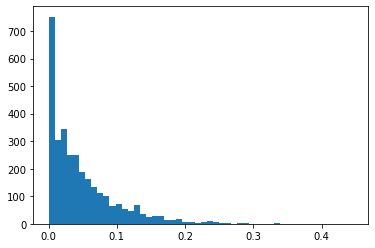

In [6]:
z = plt.hist(df_scrutin['ratioabstention'], bins = 50)

On récupère les "points" de l'histogramme pour pouvoir ploter la distribution de ratioabstention 

In [7]:
x = z[1][1:]
y = z[0]
y1 = []
x1 = []
for i in range(len(y)):
    if y[i] != 0:
        y1.append(y[i])
        x1.append(x[i])

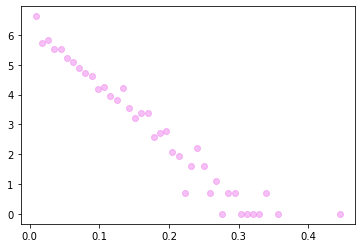

In [167]:
#x et log y
plt.plot(x1,np.log(y1), 'o', color = 'violet', alpha = 0.5, label = 'log des effectifs')

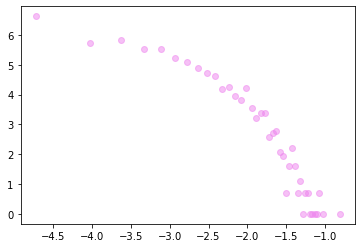

In [145]:
#log x et log y
plt.plot(np.log(x1),np.log(y1), 'o', color = 'violet', alpha = 0.5, label = 'log des effectifs')

Le premier plot s'approche beaucoup d'une droite, contrairement au second. On pense alors à une loi exponentielle plutôt qu'à une loi de puissance. On fait une régression linéaire de log(effectifs) sur le ratio pour s'assurer qu'on a bien une droite. 

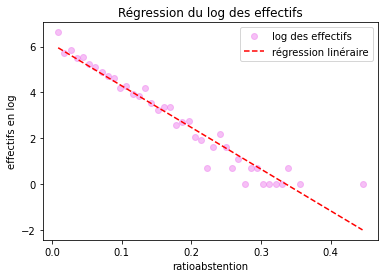

In [170]:
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x1,np.log(y1))

plt.plot(x1,np.log(y1), 'o', color = 'violet', alpha = 0.5, label = 'log des effectifs')
plt.plot(x1,[i*slope + intercept for i in x1], color = 'red', linestyle = 'dashed', label = 'régression linéraire')
plt.ylabel('effectifs en log')
plt.xlabel('ratioabstention')
plt.title('Régression du log des effectifs')
plt.legend()

On repasse à l'exponentielle pour comparer les distributions 

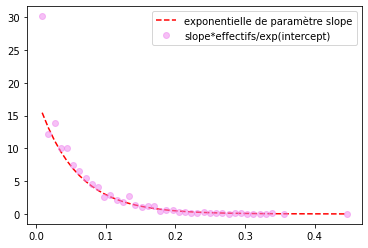

In [159]:
#exponentielle à partir des x1
liste = list(stats.expon.pdf(x1, scale = -1/slope))
plt.plot(x1, liste,color = 'red',linestyle = 'dashed', label = 'exponentielle de paramètre slope')
b = int(np.exp(intercept))
a = int(slope)
y2 = [(-a/b)*i for i in y1]
plt.plot(x1,y2, 'o', color = 'violet', alpha = 0.5, label = 'slope*effectifs/exp(intercept)')
plt.legend()

C'est la variable **slope*effectifs/exp(intercept)** qui suit une **loi exponentielle** de paramètre(-slope). Donc **y1 c'est à dire les effectifs en fonction du ratioabstention est proportionnel à une loi exponentielle de paramètre (-slope)**.

On fait un KS test pour vérifier 

In [161]:
from scipy import stats
#scipy.stats.ks_1samp(y2,stats.expon.pdf) #probability density function 
scipy.stats.ks_1samp(y2,stats.expon.cdf) #cumulative distribution function 
#statistic = norme infinie de fct de répartition de y1 - fonction de répartition de expon

KstestResult(statistic=0.2540570845262017, pvalue=0.009188949499589594)

cdf et pdf ???????? 

On essaye avec la loi de puissance : y1/exp(intercept) ne suis pas une loi de puissance de paramètre (-slope).

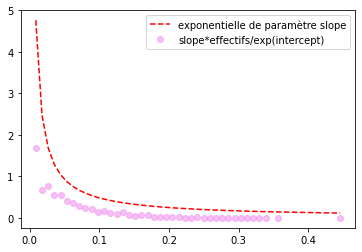

In [169]:
#powerlaw à partir des x1
liste = list(stats.powerlaw.pdf(x1,-1/slope))
plt.plot(x1, liste,color = 'red',linestyle = 'dashed', label = 'exponentielle de paramètre slope')
b = int(np.exp(intercept))
y3 = [(1/b)*i for i in y1]
plt.plot(x1,y3, 'o', color = 'violet', alpha = 0.5, label = 'slope*effectifs/exp(intercept)')
plt.legend()

**Groupes en fonction de l'abstention**

Il faut trouver la bonne valeur de séparation entre abstention moyenne et abstention forte 

635

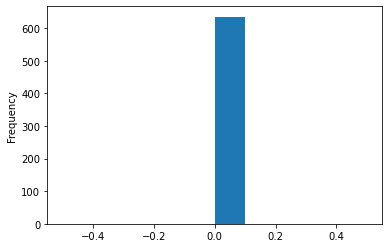

In [39]:
df_scrutin[df_scrutin['ratioabstention'].isin([0])]['ratioabstention'].plot(kind='hist')
df_scrutin[df_scrutin['ratioabstention'].isin([0])]['ratioabstention'].count()
#le premier groupe est celui où l'abstention est nulle : on a 635 observations 

2042

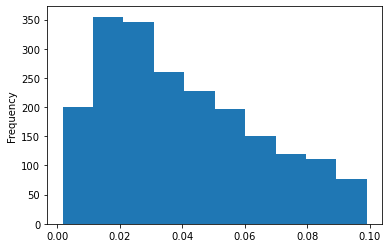

In [40]:
df_scrutin[(df_scrutin['ratioabstention'] >0) & (df_scrutin['ratioabstention']< 0.10)]['ratioabstention'].plot(kind='hist')
df_scrutin[(df_scrutin['ratioabstention'] >0) & (df_scrutin['ratioabstention']< 0.10)]['ratioabstention'].count()

442

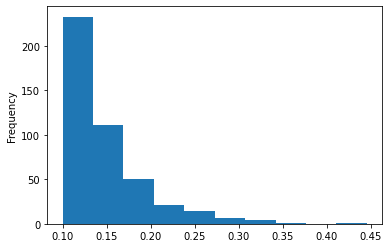

In [41]:
df_scrutin[df_scrutin['ratioabstention'] >= 0.10]['ratioabstention'].plot(kind='hist')
df_scrutin[df_scrutin['ratioabstention'] >= 0.10]['ratioabstention'].count()

In [42]:
df_scrutin['ratioabstention'].quantile(q = [0.5,0.75,0.8,0.9,0.99,0.999])

0.500    0.032000
0.750    0.067797
0.800    0.080000
0.900    0.119652
0.990    0.232973
0.999    0.332733
Name: ratioabstention, dtype: float64

moyenne à 4,6% et 3ème quartile à 6,7% => le max est vraiment très max donc apparemment certains scrutins ont eu une très forte absention par rapport aux autres -> on va essayer de regarder ces valeurs extrêmes

In [43]:
df_scrutin0 = df_scrutin[df_scrutin['ratioabstention'].isin([0])]
df_scrutin1 = df_scrutin[(df_scrutin['ratioabstention'] >0) & (df_scrutin['ratioabstention']< 0.20)]
df_scrutin2 = df_scrutin[df_scrutin['ratioabstention'] >= 0.20]

In [44]:
df_scrutin1['ratioabstention'].describe()
df_scrutin2['ratioabstention'].describe()

count    54.000000
mean      0.248402
std       0.047740
min       0.200000
25%       0.212599
50%       0.238451
75%       0.263112
max       0.445783
Name: ratioabstention, dtype: float64

ça lisse la fin de la distribution -> il faudrait voir en quoi les scrutins qu'on a enlevés, cad ceux avec des valeurs très hautes diffèrent, des autres 

on pourrait regarder aussi les scrutins où il n'y a pas du tout d'abstention -> est-ce que ça polarise plus les votes ou non ? 

Text(0.5, 1.0, "Ratio votants pour/votants total pour l'ensemble des scrutins")

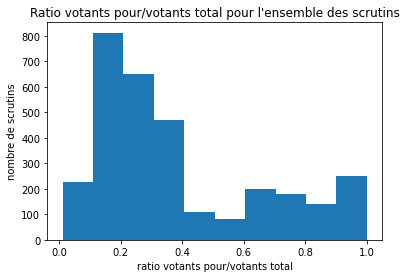

In [45]:
#on regade le pourcentage de 'pour' à chaque scrutin -> quelle majorité ? très large ou ça passe de justesse ? 
pourcentagepour = df_scrutin['pour']/df_scrutin['votants']
pourcentagepour.plot(kind='hist')
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('nombre de scrutins')
plt.title("Ratio votants pour/votants total pour l'ensemble des scrutins")

Text(0.5, 1.0, 'Ratio votants pour/votants total pour les scrutins avec une abstention nulle')

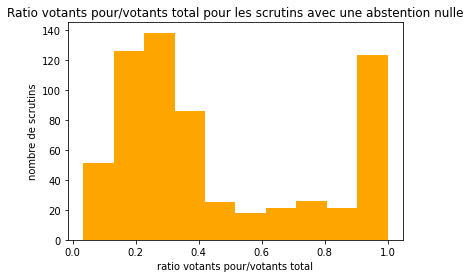

In [46]:
pourcentagepourdf0 = df_scrutin0['pour']/df_scrutin0['votants']
pourcentagepourdf0.plot(kind='hist', color='orange')
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('nombre de scrutins')
plt.title("Ratio votants pour/votants total pour les scrutins avec une abstention nulle")

In [47]:
pourcentagepourdf2 = (df2.groupby('idScrutin')['pour'].sum()/df2.groupby('idScrutin')['pour'].count())/(df2.groupby('idScrutin')['votants'].sum()/df2.groupby('idScrutin')['votants'].count())
pourcentagepourdf2 = np.array(pourcentagepourdf2)
sns.histplot(pourcentagepourdf2, stat="probability")

NameError: name 'df2' is not defined

Text(0.5, 1.0, 'Ratio votants pour/votants total pour les scrutins avec une abstention moyenne')

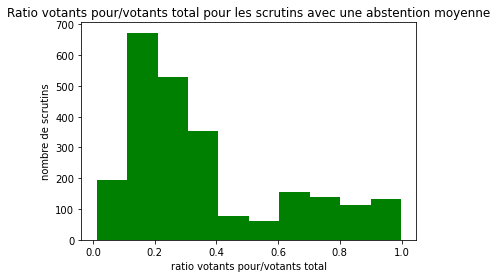

In [48]:
pourcentagepourdf1 = df_scrutin1['pour']/df_scrutin1['votants']
pourcentagepourdf1.plot(kind='hist', color='green')
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('nombre de scrutins')
plt.title("Ratio votants pour/votants total pour les scrutins avec une abstention moyenne")

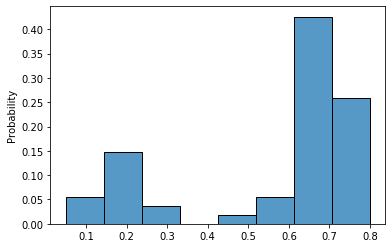

In [31]:
pourcentagepourdf3 = (df3.groupby('idScrutin')['pour'].sum()/df3.groupby('idScrutin')['pour'].count())/(df3.groupby('idScrutin')['votants'].sum()/df3.groupby('idScrutin')['votants'].count())
pourcentagepourdf3 = np.array(pourcentagepourdf3)
sns.histplot(pourcentagepourdf3, stat="probability")

Text(0.5, 1.0, 'Ratio votants pour/votants total pour les scrutins avec une abstention forte')

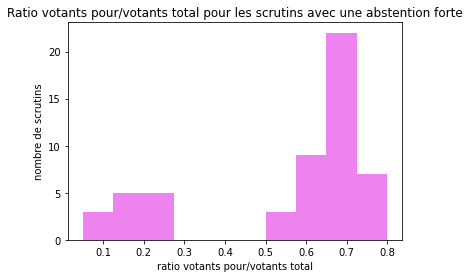

In [49]:
pourcentagepourdf2 = df_scrutin2['pour']/df_scrutin2['votants']
pourcentagepourdf2.plot(kind='hist', color='violet')
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('nombre de scrutins')
plt.title("Ratio votants pour/votants total pour les scrutins avec une abstention forte")

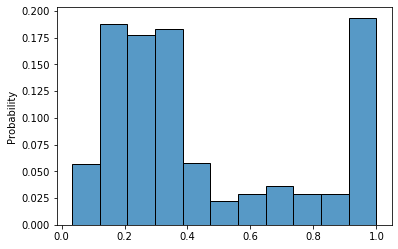

In [33]:
pourcentagepourdf4 = (df4.groupby('idScrutin')['pour'].sum()/df4.groupby('idScrutin')['pour'].count())/(df4.groupby('idScrutin')['votants'].sum()/df4.groupby('idScrutin')['votants'].count())
pourcentagepourdf4 = np.array(pourcentagepourdf4)
sns.histplot(pourcentagepourdf4, stat="probability")

**Test statistique : KS pour tester l'égalité des distributions**

The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution.
The p-value returned by the k-s test has the same interpretation as other p-values. You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.


In [21]:
import scipy
scipy.stats.kstest(df_scrutin2['ratioabstention'],df_scrutin1['abstention'])

NameError: name 'df_scrutin2' is not defined

In [51]:
scipy.stats.kstest(df_scrutin0['ratioabstention'],df_scrutin1['abstention'])

KstestResult(statistic=1.0, pvalue=0.0)

In [52]:
scipy.stats.kstest(df_scrutin0['ratioabstention'],df_scrutin2['abstention'])

KstestResult(statistic=1.0, pvalue=0.0)

**Histogramme normé**

Il faudrait le pimper avec seaborn mais ça marche pas ici...

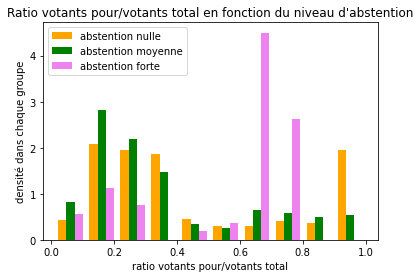

In [53]:
plt.hist([pourcentagepourdf0, pourcentagepourdf1, pourcentagepourdf2], color = ['orange', 'green', 'violet'],
            histtype = 'bar', label = ['abstention nulle', 'abstention moyenne', 'abstention forte'], density = True) 
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('densité dans chaque groupe')
plt.title("Ratio votants pour/votants total en fonction du niveau d'abstention")
plt.legend()

Si les distributions orange et verte (abstention moyenne et nulle) se ressemblent, on voit que la distrubtion rose (abstention forte) diffère (quasiment en symétrique). Les scrutins où l'abstention est très forte sont des scrutins où les votes sont très consensuels : plus des 3/4 des scrutins sont adoptés avec plus de 60% de vote pour. A l'inverse, lorsque l'abstention est moyenne ou nulle, les scrutins sont moins souvent adoptés (les votes pour ne dépassent pas les 40% pour les 2/3 des scrutins), sauf une exeption pour la denière barre orange (à expliquer mieux). 


**Courbes pas utiles**

In [41]:
pourcentagepourdf4tri = pourcentagepourdf4.sort_values(ascending=False)
listepourcentagepourdf4 = list(pourcentagepourdf4tri)
pourcentagepourdf2tri = pourcentagepourdf2.sort_values(ascending=False)
listepourcentagepourdf2 = list(pourcentagepourdf2tri)
pourcentagepourdf3tri = pourcentagepourdf3.sort_values(ascending=False)
listepourcentagepourdf3 = list(pourcentagepourdf3tri)
pourcentagepourtri = pourcentagepour.sort_values(ascending=False)
listepourcentagepour = list(pourcentagepourtri)

Text(0.5, 1.0, 'Ratio votants pour/votants total en fonction des scrutins à abstention moyenne')

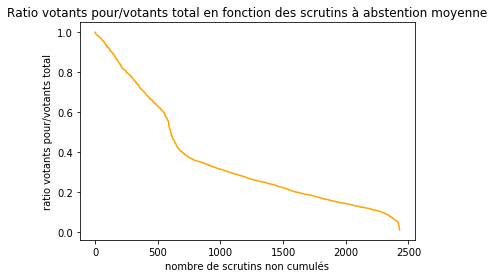

In [42]:
plt.plot(listepourcentagepourdf2, color ='orange')
plt.xlabel('nombre de scrutins non cumulés')
plt.ylabel('ratio votants pour/votants total')
plt.title('Ratio votants pour/votants total en fonction des scrutins à abstention moyenne')

Dans les cas où l'abstention est "moyenne", les votes sont peu consensuels : on a presque une droite (on aurait quasiment une bissectrice si on avait ordonné les ratios dans le sens croissant)

Text(0.5, 1.0, 'Ratio votants pour/votants total en fonction des scrutins à abstention forte')

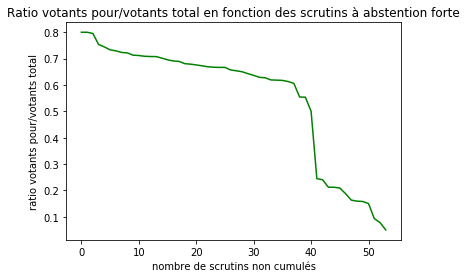

In [43]:
plt.plot(listepourcentagepourdf3, color='green')
plt.xlabel('nombre de scrutins non cumulés')
plt.ylabel('ratio votants pour/votants total')
plt.title('Ratio votants pour/votants total en fonction des scrutins à abstention forte')

Dans les cas où l'abstention est forte, la courbe n'a pas la même allure : les votes semblent beaucoup plus consensuels dans la mesure où les votants pour sont largement majoritaires (> 60%) des votants pour plus des 3/4 des scrutins

Text(0.5, 1.0, 'Ratio votants pour/votants total en fonction des scrutins à abstention nulle')

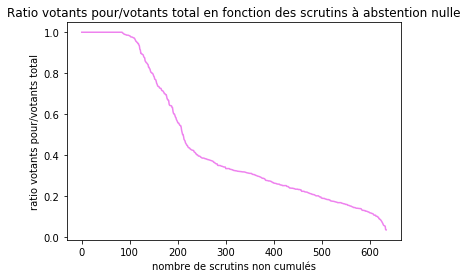

In [44]:
plt.plot(listepourcentagepourdf4, color='violet')
plt.xlabel('nombre de scrutins non cumulés')
plt.ylabel('ratio votants pour/votants total')
plt.title('Ratio votants pour/votants total en fonction des scrutins à abstention nulle')

Dans le cas où l'abstention est nulle on a presque l'inverse de la courbe pour l'abstention forte -> les votes contre sont majoritaires (votes pour <40%) pour les 2/3 des scrutins (on peut le lire comme ça car les abstentions sont nulles donc les votes non pour sont des votes contre) => idée que les députés se mobilisent plus (et donc s'abtstiennent moins) pour les scrutins avec lesquels ils sont en désaccord ? Il faudrait voir la nature de ces scrutins et voir les caractéristiques des votants qui font "barrage"